<a id='Top'></a>

# Yelp Recommender System Project
## Part 3 Recommender System (In progress)

### Overview

1. <a href='#1'>Preparation for Recommender systems</a>
1. <a href='#2'>Basic Algorithms</a>
1. <a href='#3'>Collaborative Filtering</a>
1. <a href='#4'>Content-based Filtering</a> 

_The datasets were cleaned and explored in the data wrangling and EDA parts of this project (see Data wrangling and EDA notebooks for details). Note that the datasets used here contain only __food and restaurant__ related businesses, users, and reviews._

In [1187]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from ast import literal_eval
from collections import defaultdict
import numpy as np

# Surprise 
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import AlgoBase
from surprise import PredictionImpossible

from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import CoClustering

# sklearn
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV as GridSearchCV_skl
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

<a id='1'></a>
### Preparation for Recommender systems

In [541]:
df = pd.read_csv('reviews_business_user_info.csv', index_col=0)

In [542]:
df.head(3)

,review_id,user_id,business_id,stars,date,business_name,city,state,city_state,latitude,longitude,price_range,business_review_count,categories,user_name,yelping_since,user_review_count
0,x7mDIiDB3jEiPGPHOmDzyw,msQe1u7Z_XuqjGoqhB0J5g,iCQpiavjjPzJ5_3gPD5Ebg,2,2011-02-25,Secret Pizza,Las Vegas,NV,"Las Vegas, NV",36.109837,-115.174212,1.0,4078,"['Pizza', 'Restaurants']",Melissa,2011-02-24,11
1,dDl8zu1vWPdKGihJrwQbpw,msQe1u7Z_XuqjGoqhB0J5g,pomGBqfbxcqPv14c3XH-ZQ,5,2012-11-13,Leticia's Mexican Cocina,Las Vegas,NV,"Las Vegas, NV",36.298875,-115.280088,2.0,1125,"['Restaurants', 'Mexican', 'Bars', 'Nightlife']",Melissa,2011-02-24,11
2,LZp4UX5zK3e-c5ZGSeo3kA,msQe1u7Z_XuqjGoqhB0J5g,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,H&H BBQ Plus 2,Las Vegas,NV,"Las Vegas, NV",36.241809,-115.234495,2.0,115,"['American (New)', 'Barbeque', 'Restaurants']",Melissa,2011-02-24,11


In [543]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4017884 entries, 0 to 4017883
Data columns (total 17 columns):
review_id                object
user_id                  object
business_id              object
stars                    int64
date                     object
business_name            object
city                     object
state                    object
city_state               object
latitude                 float64
longitude                float64
price_range              float64
business_review_count    int64
categories               object
user_name                object
yelping_since            object
user_review_count        int64
dtypes: float64(3), int64(3), object(11)
memory usage: 551.8+ MB


#### Selecting one metropolitan area

For building a recommender system, I will use food and restaurant businesses only in one metropolitan area for several reasons. First of all, people normally want to have recommendations in some areas they plan to visit. Moreover, if all cities are used, the matrix by users (rows) and businesses (columns) becomes very sparse and this makes it hard to predict stars.  

The city with the most number of reviews was Las Vegas.

In [544]:
df.city_state.value_counts()[:20]

Las Vegas, NV          1139203
Phoenix, AZ             408423
Toronto, ON             380025
Scottsdale, AZ          217414
Charlotte, NC           198690
Pittsburgh, PA          157270
MontrÃ©al, QC           115208
Tempe, AZ               115027
Henderson, NV           109831
Mesa, AZ                 88576
Chandler, AZ             86319
Cleveland, OH            81433
Madison, WI              71896
Gilbert, AZ              68186
Calgary, AB              63940
Glendale, AZ             53566
Mississauga, ON          39518
Markham, ON              39319
Peoria, AZ               29418
North Las Vegas, NV      25355
Name: city_state, dtype: int64

I noticed some of the other cities above are also in the [Las Vegas–Henderson–Paradise, NV  metropolitan area](https://en.wikipedia.org/wiki/Las_Vegas%E2%80%93Henderson%E2%80%93Paradise,_NV_Metropolitan_Statistical_Area). The cities belong to the metropolitan area are Henderson,  North Las Vegas, Paradise, Las Vegas, and Boulder City and I will include reviews in all of these cities. 

In the EDA part, I already transformed 5 kinds of strings representing Las Vegas into 'Las Vegas'. 'Henderson and Las vegas' actually  representing Henderson was also fixed. Here, I will further clean up strings for North Las Vegas. I did not find any multiple strings for Paradise and Boulder City. I will also check whether there are any same name cities in other states.

##### Fixing city names

In [545]:
df[df.city=='Las Vegas'].city_state.value_counts()

Las Vegas, NV    1139203
Name: city_state, dtype: int64

In [546]:
df[df.city=='Paradise'].city_state.value_counts()

Paradise, NV    110
Name: city_state, dtype: int64

In [547]:
df[df.city=='Boulder City'].city_state.value_counts()

Boulder City, NV    5746
Name: city_state, dtype: int64

In [548]:
df[df.city=='Henderson'].city_state.value_counts()

Henderson, NV    109831
Henderson, VA         3
Name: city_state, dtype: int64

There is Henderson in Virginia! Thus, I need to use the city_state column I made to select the 5 cities in my interest.

In [549]:
df[df.city.isin(['N Las Vegas', 'N. Las Vegas', 'North Las Vegas'])].city_state.value_counts()

North Las Vegas, NV    25355
N. Las Vegas, NV         287
N Las Vegas, NV          113
Name: city_state, dtype: int64

They are altogether 25755 and 'N Las Vegas' and 'N. Las Vegas'(400 of them) will be fixed to 'North Las Vegas'.

In [550]:
# function from the EDA part
def unify_city_names(df, col_name, possible_names, correct_name):
    '''
    This function correct all possible city names to a correct name
    '''
    correct_dict = dict(zip(possible_names,[correct_name]*len(possible_names)))
    print(correct_dict)
    df[col_name]=df[col_name].replace(correct_dict)

In [551]:
unify_city_names(df, 'city', ['N Las Vegas', 'N. Las Vegas'], 'North Las Vegas')

{'N Las Vegas': 'North Las Vegas', 'N. Las Vegas': 'North Las Vegas'}


In [552]:
sum(df.city.isin(['N Las Vegas', 'N. Las Vegas'])) 

0

In [553]:
sum(df.city=='North Las Vegas')

25755

The number looks correct! I also need to fix the city_state column.

In [554]:
sum(df.city_state=='North Las Vegas, NV')

25355

In [555]:
sum(df.city_state.isin(['N Las Vegas, NV', 'N. Las Vegas, NV']))

400

In [556]:
unify_city_names(df, 'city_state', ['N Las Vegas, NV', 'N. Las Vegas, NV'], 'North Las Vegas, NV')

{'N Las Vegas, NV': 'North Las Vegas, NV', 'N. Las Vegas, NV': 'North Las Vegas, NV'}


In [557]:
sum(df.city_state.isin(['N Las Vegas, NV', 'N. Las Vegas, NV']))

0

In [558]:
sum(df.city_state=='North Las Vegas, NV')

25755

##### Selecting reviews in those cities

In [559]:
city_states_Vegas = ['Las Vegas, NV','North Las Vegas, NV','Paradise, NV',
                    'Boulder City, NV', 'Henderson, NV']

In [560]:
1139203+110+5746+109831+25755

1280645

In [561]:
df_Vegas = df[df.city_state.isin(city_states_Vegas)]
len(df_Vegas)

1280645

In [562]:
len(df_Vegas) == 1139203+110+5746+109831+25755

True

The number of reviews, 1,280,645, looks alright!

In [563]:
df_Vegas.city_state.unique()

array(['Las Vegas, NV', 'Henderson, NV', 'Boulder City, NV',
       'North Las Vegas, NV', 'Paradise, NV'], dtype=object)

In [564]:
# Number of users
df_Vegas.user_id.nunique()

422409

In [565]:
# Number of businesses
df_Vegas.business_id.nunique()

9674

The Las Vegas reviews have 
- 1,280,645 reviews
- 422,409 users  
- 9,674 businesses 

In [566]:
# save Vegas reviews
#df_Vegas.to_csv('reviews_business_user_info_Vegas.csv')

#### Selecting businesses and users with enough reviews

In [567]:
def ids_with_enough_reviews(df, column, threshold):
    review_counts = df[column].value_counts() 
    return review_counts[review_counts >= threshold].index

In [568]:
sum(df_Vegas.user_id.value_counts()>=10)

20340

In [569]:
user_ids_10more = ids_with_enough_reviews(df_Vegas, 'user_id', 10)

In [570]:
df_Vegas[df_Vegas.user_id.isin(user_ids_10more)].user_id.nunique()

20340

In [571]:
sum(df_Vegas.business_id.value_counts()>=20)

6268

In [572]:
business_ids_20more = ids_with_enough_reviews(df_Vegas, 'business_id', 20)

In [573]:
df_Vegas[df_Vegas.business_id.isin(business_ids_20more)].business_id.nunique()

6268

In [574]:
len(df_Vegas[(df_Vegas.business_id.isin(business_ids_20more))&(df_Vegas.user_id.isin(user_ids_10more))])

493658

In [575]:
df_Vegas_over_10_20 = df_Vegas[(df_Vegas.business_id.isin(business_ids_20more))&(df_Vegas.user_id.isin(user_ids_10more))]

In [576]:
df_Vegas_over_10_20.user_id.nunique(), df_Vegas_over_10_20.business_id.nunique(), len(df_Vegas_over_10_20)

(20340, 6266, 493658)

In [577]:
df_Vegas_over_10_20.user_id.nunique(), df_Vegas_over_10_20.business_id.nunique(), len(df_Vegas_over_10_20)

(20340, 6266, 493658)

After removing users with less than 10 reviews and businesses with less than 20 reviews, the dataset has
- 493,658 reviews
- 20,340 users
- 6,266 businesses

Note that the reviews left can have users with less than 10 reviews and businesses less than 20 reviews since removing users can further reduce businesses and vice versa.

In [578]:
df_Vegas_over_10_20.to_csv('reviews_business_user_info_Vegas_over_10_20.csv')

Now it's time to build recommender systems!

First, I am going to use the recommender system package called [Surprise](https://surprise.readthedocs.io/en/stable/index.html) for basic and collaborative filtering algorithms. Then, I will build content-based algorithms using sklearn.

In [579]:
df_Vegas_over_10_20[(df_Vegas_over_10_20.user_id=='U4INQZOPSUaj8hMjLlZ3KA')&(df_Vegas_over_10_20.business_id=='4JNXUYY8wbaaDmk3BPzlWw')]

,review_id,user_id,business_id,stars,date,business_name,city,state,city_state,latitude,longitude,price_range,business_review_count,categories,user_name,yelping_since,user_review_count
3528833,cpxD9Yxtv_xu8lf-q38dJA,U4INQZOPSUaj8hMjLlZ3KA,4JNXUYY8wbaaDmk3BPzlWw,3,2009-10-12,Mon Ami Gabi,Las Vegas,NV,"Las Vegas, NV",36.112827,-115.172581,2.0,7968,"['Steakhouses', 'Breakfast & Brunch', 'Restaur...",Michael,2008-01-31,4182


#### Split test and training sets

In [580]:
# Load the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_Vegas_over_10_20[['user_id', 'business_id', 'stars']], reader)
raw_ratings = data.raw_ratings

# shuffle ratings 
random.Random(32).shuffle(raw_ratings)

# 90% training and 10% test data
threshold = int(.9 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

In [581]:
raw_ratings[:5]

[('U4INQZOPSUaj8hMjLlZ3KA', '4JNXUYY8wbaaDmk3BPzlWw', 3.0, None),
 ('cg2P244yON3-_GXWkgAgsw', 'umXvdus9LbC6oxtLdXelFQ', 4.0, None),
 ('YHdXkAmndIfuIczWOnsjeQ', '7HIa2lYy5jgcZuADlRjKSg', 1.0, None),
 ('CstEf6M4JSom9Msm0qIYew', 'wdOOK3K6vzQy1d_OIk-U9w', 3.0, None),
 ('Cwkkowhq9MZue1Xyk57BMg', '7sPNbCx7vGAaH7SbNPZ6oA', 4.0, None)]

#### Make helper functions

In [479]:
def training_test_algorithm(train_set, test_set, algorithm, param_grid, n_cv, cv_result=True):

    data.raw_ratings = train_set  

    # grid search cross validation
    gs = GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=n_cv, n_jobs=-1)
    gs.fit(data)
    best_algo = gs.best_estimator['rmse']
    # hyper-parameters for the best RMSE score
    best_params = gs.best_params['rmse']
    print("Best hyper-parameters:", best_params)
    print()
    
    # show RMSE for each hyper-parameter combination if cv_result=True
    # if cv_result=False, only show the RMSE for the best combination
    if cv_result:
        print("Training set RMSE for each hyper-parameter combination:")
    else:
        print("Training set RMSE for the best hyper-parameter combination:")
    means = gs.cv_results['mean_test_rmse']
    stds = gs.cv_results['std_test_rmse']
    parameters = gs.cv_results['params']
    for mean, std, params in zip(means, stds, parameters):
        if (cv_result)|(params == best_params):
            print("%0.4f (+/-%0.04f) for %r" % (mean, std * 2, params))                
    print()

    # Compute performance on the whole training set 
    trainset = data.build_full_trainset()
    best_algo.fit(trainset)
    pred = best_algo.test(trainset.build_testset())
#    print('Train set', end='  ')
#    accuracy.rmse(pred)
    
    # Compute performance on test set
    testset = data.construct_testset(test_set)  # testset is now the set B
    pred = best_algo.test(testset)
    print('Test set', end='  ')
    accuracy.rmse(pred)

Surprise GridSearchCV accepts only classes, so I added all hyper-parameters (e.g., random_state) of an algorithm as a grid search parameter whether it is tuned or not. https://github.com/NicolasHug/Surprise/issues/212

<a id='2'></a>
### Basic Algorithms

I will first try the most basic algorithms.

#### NormalPredictor algorithm

NormalPredictor predicts ratings randomly from the normal distribution with mean and standard deviation estimated by the training set. This is a good base model to be compared with more complex models. Click [here](https://surprise.readthedocs.io/en/stable/basic_algorithms.html) for more details. 

In [40]:
%%time
param_grid = {}
training_test_algorithm(train_raw_ratings, test_raw_ratings, NormalPredictor, param_grid, n_cv=3)

Best hyper-parameters: {}

Training set RMSE for each hyper-parameter combination:
1.6269 (+/-0.0041) for {}

Test set  RMSE: 1.6317
Wall time: 26.1 s


#### Just mean algorithm

This algorithm uses just the mean of all ratings in the training set.

In [293]:
# Mean of the training set
ratings = [r for _, _, r, _ in train_raw_ratings]
sum(ratings)/len(ratings)

3.7656181070107047

In [295]:
class Just_mean(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        return 3.7656

#algo = Just_mean()
#cross_validate(algo, data, verbose=True)

In [294]:
%%time
param_grid = {}
training_test_algorithm(train_raw_ratings, test_raw_ratings, Just_mean, param_grid, n_cv=3)

Best hyper-parameters: {}

Training set RMSE for each hyper-parameter combination:
1.2353 (+/-0.0044) for {}

Test set  RMSE: 1.2362
Wall time: 22.9 s


This simpler model using only mean is much better than the normal predictor with randomness.

<a id='3'></a>
### Collaborative Filtering

The collaborative filtering algorithms predict preference or ratings of a user on an item using preference or ratings of other users. These do not utilize metadata of items or users.

#### Baseline Algorithm

The [baseline algorithm](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration) predicts ratings using the mean ratings plus user and item biases, parameters to be optimized. It also has the regularization term with squares of the biases.  

In [41]:
%%time
param_grid = {}
training_test_algorithm(train_raw_ratings, test_raw_ratings, BaselineOnly, param_grid, n_cv=3)

Best hyper-parameters: {}

Training set RMSE for each hyper-parameter combination:
1.1062 (+/-0.0029) for {}

Estimating biases using als...
Test set  RMSE: 1.0941
Wall time: 27 s


- The baseline model is much better than the Just_mean model! With tuning, this algorithm is expected to be improved even further.
- By default, the above used Alternating Least Squares (ALS) and I am going to check how Stochastic Gradient Descent (SGD) peforms.
- I also tried n_cv=5 for many algorithms, but it did not improve the performance on the test set although the performanceo on the training set is a little better with 5. Thus, I decided just use 3 since it saves time.

In [52]:
%%time
param_grid = {'bsl_options':{'method': ['als','sgd']}}
training_test_algorithm(train_raw_ratings, test_raw_ratings, BaselineOnly, param_grid, n_cv=3)

Best hyper-parameters: {'bsl_options': {'method': 'sgd'}}

Training set RMSE for each hyper-parameter combination:
1.1063 (+/-0.0027) for {'bsl_options': {'method': 'als'}}
1.1005 (+/-0.0025) for {'bsl_options': {'method': 'sgd'}}

Estimating biases using sgd...
Test set  RMSE: 1.0891
Wall time: 42.4 s


SGD is slightly better (lower RMSE) than the default method ALS for the baseline model!

In [70]:
%%time
param_grid = {'bsl_options':{'method': ['sgd'],'n_epochs': [10,20,30]}}
training_test_algorithm(train_raw_ratings, test_raw_ratings, BaselineOnly, param_grid, n_cv=3)

Best hyper-parameters: {'bsl_options': {'method': 'sgd', 'n_epochs': 20}}

Training set RMSE for each hyper-parameter combination:
1.1078 (+/-0.0031) for {'bsl_options': {'method': 'sgd', 'n_epochs': 10}}
1.0999 (+/-0.0025) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20}}
1.1002 (+/-0.0024) for {'bsl_options': {'method': 'sgd', 'n_epochs': 30}}

Estimating biases using sgd...
Test set  RMSE: 1.0891
Wall time: 59.8 s


In [57]:
%%time
param_grid = {'bsl_options':{'method': ['sgd'],'n_epochs': [20, 30, 40],
                            'reg':[.05,.1,.15], 'learning_rate':[.002,.005,.01]}}
training_test_algorithm(train_raw_ratings, test_raw_ratings, BaselineOnly, param_grid, n_cv=3)

Best hyper-parameters: {'bsl_options': {'method': 'sgd', 'n_epochs': 30, 'reg': 0.1, 'learning_rate': 0.005}}

Training set RMSE for each hyper-parameter combination:
1.1130 (+/-0.0023) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.05, 'learning_rate': 0.002}}
1.1002 (+/-0.0024) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.05, 'learning_rate': 0.005}}
1.1024 (+/-0.0026) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.05, 'learning_rate': 0.01}}
1.1137 (+/-0.0022) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.1, 'learning_rate': 0.002}}
1.1004 (+/-0.0023) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.1, 'learning_rate': 0.005}}
1.1017 (+/-0.0024) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.1, 'learning_rate': 0.01}}
1.1146 (+/-0.0021) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.15, 'learning_rate': 0.002}}
1.1009 (+/-0.0022) for {'bsl_options': {'method': 'sgd', 'n_e

In [71]:
%%time
param_grid = {'bsl_options':{'method': ['sgd'],'n_epochs': [20,30,40,50,70,100],
                            'reg':[.01,.015,.02,.05,.1,.15,.2], 'learning_rate':[.005]}}
training_test_algorithm(train_raw_ratings, test_raw_ratings, BaselineOnly, param_grid, n_cv=3)

Best hyper-parameters: {'bsl_options': {'method': 'sgd', 'n_epochs': 30, 'reg': 0.1, 'learning_rate': 0.005}}

Training set RMSE for each hyper-parameter combination:
1.0999 (+/-0.0046) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.01, 'learning_rate': 0.005}}
1.0999 (+/-0.0046) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.015, 'learning_rate': 0.005}}
1.0999 (+/-0.0046) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.02, 'learning_rate': 0.005}}
1.0998 (+/-0.0046) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.05, 'learning_rate': 0.005}}
1.1000 (+/-0.0045) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.1, 'learning_rate': 0.005}}
1.1006 (+/-0.0044) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.15, 'learning_rate': 0.005}}
1.1015 (+/-0.0043) for {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.2, 'learning_rate': 0.005}}
1.1005 (+/-0.0046) for {'bsl_options': {'method': 'sgd', 

#### SVD algorithm

The Singular value decomposition (SVD), a matrix factorization method, is a popular collaborative filtering algorithm done on the user-item rating matrix. The formulas for SVD in the Surprise package are [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) and also click [here](https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9) for easy explanation.

In [42]:
%%time
param_grid = {'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1151 (+/-0.0057) for {'random_state': 32}

Test set  RMSE: 1.1066
Wall time: 1min 3s


SVD without tuning hyper-parameters is not better than the baseline models.

In [43]:
%%time
param_grid = {'n_epochs':[10, 20, 30], 'lr_all': [0.002, 0.005,.01], 
              'reg_all': [0.02, 0.05, .1], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1367 (+/-0.0066) for {'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02, 'random_state': 32}
1.1364 (+/-0.0066) for {'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.05, 'random_state': 32}
1.1364 (+/-0.0066) for {'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.1, 'random_state': 32}
1.1149 (+/-0.0063) for {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02, 'random_state': 32}
1.1133 (+/-0.0063) for {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.05, 'random_state': 32}
1.1124 (+/-0.0063) for {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.1, 'random_state': 32}
1.1147 (+/-0.0059) for {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02, 'random_state': 32}
1.1080 (+/-0.0059) for {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.05, 'random_state': 32}
1.1045 (+/-0.0059) for {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.1, 'random_state': 32}
1.1188 (+/

In [45]:
%%time
param_grid = {'n_epochs':[30,50,70,90], 'lr_all': [.001,.002, 0.005], 
              'reg_all': [ .1, .2, .3, .5], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 90, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1247 (+/-0.0007) for {'n_epochs': 30, 'lr_all': 0.001, 'reg_all': 0.1, 'random_state': 32}
1.1254 (+/-0.0008) for {'n_epochs': 30, 'lr_all': 0.001, 'reg_all': 0.2, 'random_state': 32}
1.1271 (+/-0.0009) for {'n_epochs': 30, 'lr_all': 0.001, 'reg_all': 0.3, 'random_state': 32}
1.1313 (+/-0.0010) for {'n_epochs': 30, 'lr_all': 0.001, 'reg_all': 0.5, 'random_state': 32}
1.1094 (+/-0.0012) for {'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.1, 'random_state': 32}
1.1098 (+/-0.0013) for {'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}
1.1116 (+/-0.0013) for {'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.3, 'random_state': 32}
1.1168 (+/-0.0013) for {'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.5, 'random_state': 32}
1.1045 (+/-0.0020) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1, 'random_state': 32}
1.1022 (+/-0.

In [58]:
%%time
param_grid = {'n_epochs':[80,90,100], 'lr_all': [.001,.002, 0.005], 
              'reg_all': [ .1, .2, .3], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1054 (+/-0.0022) for {'n_epochs': 80, 'lr_all': 0.001, 'reg_all': 0.1, 'random_state': 32}
1.1055 (+/-0.0021) for {'n_epochs': 80, 'lr_all': 0.001, 'reg_all': 0.2, 'random_state': 32}
1.1074 (+/-0.0021) for {'n_epochs': 80, 'lr_all': 0.001, 'reg_all': 0.3, 'random_state': 32}
1.1042 (+/-0.0025) for {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.1, 'random_state': 32}
1.1017 (+/-0.0024) for {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}
1.1031 (+/-0.0023) for {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.3, 'random_state': 32}
1.1168 (+/-0.0028) for {'n_epochs': 80, 'lr_all': 0.005, 'reg_all': 0.1, 'random_state': 32}
1.1049 (+/-0.0028) for {'n_epochs': 80, 'lr_all': 0.005, 'reg_all': 0.2, 'random_state': 32}
1.1045 (+/-0.0025) for {'n_epochs': 80, 'lr_all': 0.005, 'reg_all': 0.3, 'random_state': 32}
1.1044 (+/-0.

In [73]:
%%time
param_grid = {'n_epochs':[70,80,90], 'lr_all': [.001,.002, 0.005], 
              'reg_all': [ .15, .2, .25], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1068 (+/-0.0063) for {'n_epochs': 70, 'lr_all': 0.001, 'reg_all': 0.15, 'random_state': 32}
1.1073 (+/-0.0063) for {'n_epochs': 70, 'lr_all': 0.001, 'reg_all': 0.2, 'random_state': 32}
1.1081 (+/-0.0063) for {'n_epochs': 70, 'lr_all': 0.001, 'reg_all': 0.25, 'random_state': 32}
1.1022 (+/-0.0058) for {'n_epochs': 70, 'lr_all': 0.002, 'reg_all': 0.15, 'random_state': 32}
1.1022 (+/-0.0059) for {'n_epochs': 70, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}
1.1027 (+/-0.0060) for {'n_epochs': 70, 'lr_all': 0.002, 'reg_all': 0.25, 'random_state': 32}
1.1075 (+/-0.0055) for {'n_epochs': 70, 'lr_all': 0.005, 'reg_all': 0.15, 'random_state': 32}
1.1048 (+/-0.0058) for {'n_epochs': 70, 'lr_all': 0.005, 'reg_all': 0.2, 'random_state': 32}
1.1043 (+/-0.0059) for {'n_epochs': 70, 'lr_all': 0.005, 'reg_all': 0.25, 'random_state': 32}
1.1052 

In [74]:
%%time
param_grid = {'n_epochs':[80], 'lr_all': [.002], 
              'reg_all': [ .18, .2, .22], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.18, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1016 (+/-0.0048) for {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.18, 'random_state': 32}
1.1016 (+/-0.0048) for {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}
1.1017 (+/-0.0048) for {'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.22, 'random_state': 32}

Test set  RMSE: 1.0914
Wall time: 4min 54s


I found some smaller number of epochs are as good as big ones below. 

In [47]:
%%time
param_grid = {'n_epochs':[30], 'lr_all': [0.005], 
              'reg_all': [.15,.2,.3,.5], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1024 (+/-0.0037) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.15, 'random_state': 32}
1.1022 (+/-0.0036) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2, 'random_state': 32}
1.1035 (+/-0.0034) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.3, 'random_state': 32}
1.1084 (+/-0.0032) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.5, 'random_state': 32}

Test set  RMSE: 1.0916
Wall time: 2min 29s


In [48]:
%%time
param_grid = {'n_epochs':[30], 'lr_all': [0.005], 
              'reg_all': [.18,.2,.25], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.18, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1021 (+/-0.0028) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.18, 'random_state': 32}
1.1021 (+/-0.0027) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2, 'random_state': 32}
1.1026 (+/-0.0027) for {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.25, 'random_state': 32}

Test set  RMSE: 1.0914
Wall time: 2min 5s


In [72]:
%%time
param_grid = {'n_epochs':[20,30,40], 'lr_all': [.002, 0.005], 
              'reg_all': [.17,.18,.19,.2], 'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVD, param_grid, n_cv=3)

Best hyper-parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.18, 'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1176 (+/-0.0034) for {'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.17, 'random_state': 32}
1.1177 (+/-0.0034) for {'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.18, 'random_state': 32}
1.1178 (+/-0.0034) for {'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.19, 'random_state': 32}
1.1180 (+/-0.0034) for {'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.2, 'random_state': 32}
1.1035 (+/-0.0029) for {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.17, 'random_state': 32}
1.1035 (+/-0.0028) for {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.18, 'random_state': 32}
1.1036 (+/-0.0028) for {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.19, 'random_state': 32}
1.1037 (+/-0.0028) for {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2, 'random_state': 32}
1.1094 (+/-0.0032) for {'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.17, 'random_state': 32}
1.109

#### SVDpp algorithm

In [50]:
%%time
param_grid = {'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, SVDpp, param_grid, n_cv=3)

Best hyper-parameters: {'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1175 (+/-0.0042) for {'random_state': 32}

Test set  RMSE: 1.1108
Wall time: 9min 37s


SVDpp is so much slower (9 times!!) and higher in RMSE than SVD when both are not tuned! Thus, I will not further tune this algorithm. 

#### NMF algorithm

In [51]:
%%time
param_grid = {'random_state':[32]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, NMF, param_grid, n_cv=3)

Best hyper-parameters: {'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.2139 (+/-0.0019) for {'random_state': 32}

Test set  RMSE: 1.1755
Wall time: 1min 8s


- NMF is much worse in RMSE than SVD when not tuned, so I will not further tune this algorithm.
- I also tried 4 KNN-based algorithms in the Surprise, but they threw a memory error while I'm using only 50% of 24GB memory. 

#### Co-clustering

In [1098]:
%%time
param_grid = {'random_state':[32]} #n_epochs=20 by default
training_test_algorithm(train_raw_ratings, test_raw_ratings, CoClustering, param_grid, n_cv=3)

Best hyper-parameters: {'random_state': 32}

Training set RMSE for each hyper-parameter combination:
1.1643 (+/-0.0033) for {'random_state': 32}

Test set  RMSE: 1.1332
Wall time: 44.8 s


In [1101]:
%%time
param_grid = {'random_state':[32], 'n_epochs':[30,40,50]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, CoClustering, param_grid, n_cv=3)

Best hyper-parameters: {'random_state': 32, 'n_epochs': 30}

Training set RMSE for each hyper-parameter combination:
1.1634 (+/-0.0042) for {'random_state': 32, 'n_epochs': 30}
1.1636 (+/-0.0044) for {'random_state': 32, 'n_epochs': 40}
1.1638 (+/-0.0046) for {'random_state': 32, 'n_epochs': 50}

Test set  RMSE: 1.1333
Wall time: 1min 29s


In [1100]:
%%time
param_grid = {'random_state':[32], 'n_cltr_u':[3,4,5], 'n_cltr_i':[3,4,5]}
training_test_algorithm(train_raw_ratings, test_raw_ratings, CoClustering, param_grid, n_cv=3)

Best hyper-parameters: {'random_state': 32, 'n_cltr_u': 3, 'n_cltr_i': 3}

Training set RMSE for each hyper-parameter combination:
1.1636 (+/-0.0053) for {'random_state': 32, 'n_cltr_u': 3, 'n_cltr_i': 3}
1.1662 (+/-0.0060) for {'random_state': 32, 'n_cltr_u': 3, 'n_cltr_i': 4}
1.1688 (+/-0.0048) for {'random_state': 32, 'n_cltr_u': 3, 'n_cltr_i': 5}
1.1712 (+/-0.0030) for {'random_state': 32, 'n_cltr_u': 4, 'n_cltr_i': 3}
1.1692 (+/-0.0044) for {'random_state': 32, 'n_cltr_u': 4, 'n_cltr_i': 4}
1.1746 (+/-0.0028) for {'random_state': 32, 'n_cltr_u': 4, 'n_cltr_i': 5}
1.1780 (+/-0.0037) for {'random_state': 32, 'n_cltr_u': 5, 'n_cltr_i': 3}
1.1848 (+/-0.0057) for {'random_state': 32, 'n_cltr_u': 5, 'n_cltr_i': 4}
1.1818 (+/-0.0056) for {'random_state': 32, 'n_cltr_u': 5, 'n_cltr_i': 5}

Test set  RMSE: 1.1332
Wall time: 2min 58s


<a id='4'></a>
### Content-Based Filtering 

The Content-based filtering algorithms use item or user's metadata (e.g., content of films or demographic profile of users) to predict ratings or preferences for recommendations. Here I will use the data for businesses to predict star ratings.

#### Prepare metadata

In [464]:
df_Vegas_over_10_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493658 entries, 62 to 4017804
Data columns (total 17 columns):
review_id                493658 non-null object
user_id                  493658 non-null object
business_id              493658 non-null object
stars                    493658 non-null int64
date                     493658 non-null object
business_name            493658 non-null object
city                     493658 non-null object
state                    493658 non-null object
city_state               493658 non-null object
latitude                 493658 non-null float64
longitude                493658 non-null float64
price_range              493658 non-null float64
business_review_count    493658 non-null int64
categories               493658 non-null object
user_name                493658 non-null object
yelping_since            493658 non-null object
user_review_count        493658 non-null int64
dtypes: float64(3), int64(3), object(11)
memory usage: 87.8+ MB


I will use the following business features for the recommender system. 
- city (now all in Nevada, so state name is unnecessary)
- lattitude
- longitude
- prince_range
- business_review_count
- categories

The city name and categories need to be preprocessed since they are strings and list of strings, respectively.

In [ ]:
# remove uncessary columns
#df = df.drop([], axis=1)

##### categories

In [603]:
# strings back to lists (i.e., remove '' outside [])
df_Vegas_over_10_20.loc[:,'categories'] = df_Vegas_over_10_20.categories.apply(lambda x: literal_eval(x))

In [604]:
# check if the transformation was well done
for row in df_Vegas_over_10_20.categories[:5]:
    print(row, type(row))

['Nightlife', 'Japanese', 'Karaoke', 'Sushi Bars', 'Restaurants'] <class 'list'>
['Beer Gardens', 'Nightlife', 'Thai', 'Restaurants'] <class 'list'>
['Nightlife', 'Pizza', 'Wine Bars', 'Bars', 'Italian', 'Restaurants'] <class 'list'>
['Noodles', 'Japanese', 'Restaurants', 'Ramen'] <class 'list'>
['Live/Raw Food', 'Bars', 'Nightlife', 'Cocktail Bars', 'Sushi Bars', 'Seafood', 'Restaurants'] <class 'list'>


In [658]:
category_counts = defaultdict(list)
for category in category_list:
    condition = df_Vegas_over_10_20.categories.apply(lambda x: (category in x))
    business_count = df_Vegas_over_10_20[condition].business_id.nunique()
    review_count = sum(condition)
    category_counts[category] = [business_count, review_count]

In [659]:
len(category_counts)

439

There are 439 categories over all. I will reduce this number since each of categories will become a feature of businesses. To do this, I am going to check how many businesses each category was used for and remove infrequent categories.

In [660]:
category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index')
category_counts_df.columns =['business_count','review_count']

In [684]:
# Top categories sorted by number of businesses
category_counts_df.sort_values(by='business_count', ascending=False)[:100]

,business_count,review_count
Restaurants,5211,445901
Food,2218,153104
Nightlife,869,92369
American (Traditional),830,79669
Bars,820,88944
Fast Food,748,28088
Mexican,672,41049
American (New),602,77934
Sandwiches,584,44482
Pizza,564,37414


In [691]:
# Top categories sorted by number of reviews
#category_counts_df.sort_values(by='review_count', ascending=False)[:100]

In [685]:
# Number of categories ovelapping in the top business and top review categories
top_business_categories = category_counts_df.sort_values(by='business_count', ascending=False)[:100].index
top_review_categories = category_counts_df.sort_values(by='review_count', ascending=False)[:100].index
len(set(top_business_categories).intersection(set(top_review_categories)))

91

I am going to use the top 100 categories in businesses. 91 of them are also in the top review categories. The df_Vegas_over_10_20 now will be extended with 100 more columns, one for each category. Each category column will contain 1 if the review is given for a business with the corresponding category and 0, otherwise.

In [695]:
for category in top_business_categories:
    df_Vegas_over_10_20[category] = df_Vegas_over_10_20.categories.apply(lambda x: category in x)*1 

In [697]:
df_Vegas_over_10_20.head(3)

,review_id,user_id,business_id,stars,date,business_name,city,state,city_state,latitude,...,Hotels,Cosmetics & Beauty Supply,Candy Stores,Poke,Cajun/Creole,Beer Bar,Flowers & Gifts,Karaoke,Custom Cakes,Music Venues
62,66FSK2J1uHJqVI1Z8QiFGw,Yy_iGXxLpL6tYDQoE-6XVg,6tSvz_21BMo3a4GaItwa0g,4,2017-04-08,Jjanga Japanese Restaurant,Las Vegas,NV,"Las Vegas, NV",36.123557,...,0,0,0,0,0,0,0,1,0,0
63,smfJ-FC5iokX7AbGbTMD4Q,Yy_iGXxLpL6tYDQoE-6XVg,-ed0Yc9on37RoIoG2ZgxBA,3,2017-03-22,Le Thai,Las Vegas,NV,"Las Vegas, NV",36.168802,...,0,0,0,0,0,0,0,0,0,0
64,1QR6BgzXhpo7ngGEw-BW4w,Yy_iGXxLpL6tYDQoE-6XVg,XiN6fI8I3Mzg2nPRJ9ukRQ,5,2017-09-17,Prosecco Fresh Italian Kitchen,Las Vegas,NV,"Las Vegas, NV",36.028232,...,0,0,0,0,0,0,0,0,0,0


In [698]:
df_Vegas_over_10_20.Restaurants.sum()

445901

##### City 

In [699]:
one_hot = pd.get_dummies(df_Vegas_over_10_20.city)

In [702]:
one_hot.sum()

Boulder City         1677
Henderson           52024
Las Vegas          429709
North Las Vegas     10211
Paradise               37
dtype: int64

In [703]:
df_Vegas_over_10_20 = df_Vegas_over_10_20.join(one_hot)

In [948]:
df_Vegas_over_10_20.head(3)

,review_id,user_id,business_id,stars,date,business_name,city,state,city_state,latitude,...,Beer Bar,Flowers & Gifts,Karaoke,Custom Cakes,Music Venues,Boulder City,Henderson,Las Vegas,North Las Vegas,Paradise
62,66FSK2J1uHJqVI1Z8QiFGw,Yy_iGXxLpL6tYDQoE-6XVg,6tSvz_21BMo3a4GaItwa0g,4,2017-04-08,Jjanga Japanese Restaurant,Las Vegas,NV,"Las Vegas, NV",36.123557,...,0,0,1,0,0,0,0,1,0,0
63,smfJ-FC5iokX7AbGbTMD4Q,Yy_iGXxLpL6tYDQoE-6XVg,-ed0Yc9on37RoIoG2ZgxBA,3,2017-03-22,Le Thai,Las Vegas,NV,"Las Vegas, NV",36.168802,...,0,0,0,0,0,0,0,1,0,0
64,1QR6BgzXhpo7ngGEw-BW4w,Yy_iGXxLpL6tYDQoE-6XVg,XiN6fI8I3Mzg2nPRJ9ukRQ,5,2017-09-17,Prosecco Fresh Italian Kitchen,Las Vegas,NV,"Las Vegas, NV",36.028232,...,0,0,0,0,0,0,0,1,0,0


In [713]:
columns_used = ['user_id', 'business_id', 'latitude', 'longitude', 'price_range', 'business_review_count'] \
               + list(top_business_categories) \
               + ['Boulder City', 'Henderson', 'Las Vegas', 'North Las Vegas', 'Paradise'] \
               + ['stars']

In [716]:
df_sample =df_Vegas_over_10_20[columns_used]

In [719]:
df_sample.head()

,user_id,business_id,latitude,longitude,price_range,business_review_count,Restaurants,Food,Nightlife,American (Traditional),...,Flowers & Gifts,Karaoke,Custom Cakes,Music Venues,Boulder City,Henderson,Las Vegas,North Las Vegas,Paradise,stars
62,Yy_iGXxLpL6tYDQoE-6XVg,6tSvz_21BMo3a4GaItwa0g,36.123557,-115.207538,2.0,1096,1,0,1,0,...,0,1,0,0,0,0,1,0,0,4
63,Yy_iGXxLpL6tYDQoE-6XVg,-ed0Yc9on37RoIoG2ZgxBA,36.168802,-115.139880,2.0,1590,1,0,1,0,...,0,0,0,0,0,0,1,0,0,3
64,Yy_iGXxLpL6tYDQoE-6XVg,XiN6fI8I3Mzg2nPRJ9ukRQ,36.028232,-115.114936,2.0,378,1,0,1,0,...,0,0,0,0,0,0,1,0,0,5
65,Yy_iGXxLpL6tYDQoE-6XVg,BEtgRzNeXGAf0uQ-HuSyfA,36.058065,-115.278394,2.0,361,1,0,0,0,...,0,0,0,0,0,0,1,0,0,5
66,Yy_iGXxLpL6tYDQoE-6XVg,7wHLFohwCw8l6WS-feLjeg,36.122913,-115.279937,2.0,555,1,0,1,0,...,0,0,0,0,0,0,1,0,0,5


In [720]:
len(df_sample)

493658

In [721]:
shuffled_idx = list(range(len(df_sample)))
random.Random(32).shuffle(shuffled_idx)

In [722]:
shuffled_idx[:5]

[419483, 192516, 166277, 161478, 171773]

In [724]:
# 90% training and 10% test data
threshold = int(.9 * len(df_sample))
df_sample_train = (df_sample.iloc[shuffled_idx,:]).iloc[:threshold,:]
df_sample_test = (df_sample.iloc[shuffled_idx,:]).iloc[threshold:,:]

I will check if the split made the training and test sets same as before. This checking step is necessary for fair comparison between collaborative and content-based filterings. 

In [949]:
df_sample_train[['user_id','business_id','stars']][:5]

,user_id,business_id,stars
3528833,U4INQZOPSUaj8hMjLlZ3KA,4JNXUYY8wbaaDmk3BPzlWw,3
1966887,cg2P244yON3-_GXWkgAgsw,umXvdus9LbC6oxtLdXelFQ,4
1777578,YHdXkAmndIfuIczWOnsjeQ,7HIa2lYy5jgcZuADlRjKSg,1
1740381,CstEf6M4JSom9Msm0qIYew,wdOOK3K6vzQy1d_OIk-U9w,3
1822484,Cwkkowhq9MZue1Xyk57BMg,7sPNbCx7vGAaH7SbNPZ6oA,4


In [816]:
train_raw_ratings[:5] 

[('U4INQZOPSUaj8hMjLlZ3KA', '4JNXUYY8wbaaDmk3BPzlWw', 3.0, None),
 ('cg2P244yON3-_GXWkgAgsw', 'umXvdus9LbC6oxtLdXelFQ', 4.0, None),
 ('YHdXkAmndIfuIczWOnsjeQ', '7HIa2lYy5jgcZuADlRjKSg', 1.0, None),
 ('CstEf6M4JSom9Msm0qIYew', 'wdOOK3K6vzQy1d_OIk-U9w', 3.0, None),
 ('Cwkkowhq9MZue1Xyk57BMg', '7sPNbCx7vGAaH7SbNPZ6oA', 4.0, None)]

In [950]:
df_sample_test[['user_id','business_id','stars']][:5]

,user_id,business_id,stars
1867171,rdz9QHEPoecQ7DJk49ZI-g,ZrXYLXcEcDvYYBErmafobg,4
1036395,uByIGcI5EJeKNGyBtCkWBw,HyKxWC9PrqlODjO-CBCIZA,4
2119645,jmyunODJvYT7n7LCgotAyQ,0s1DqJlSSgR1Ftg9Q_HEOg,4
1042659,HJj82f-csBI7jjgenwqhvw,ALp--wAIVL4qQfCANn3ffw,4
3920469,1dWLN4Mr4hKhu8MQUCKqXQ,WXSsJIO_uGGSxS9qC8x1gQ,4


In [591]:
test_raw_ratings[:5] 

[('rdz9QHEPoecQ7DJk49ZI-g', 'ZrXYLXcEcDvYYBErmafobg', 4.0, None),
 ('uByIGcI5EJeKNGyBtCkWBw', 'HyKxWC9PrqlODjO-CBCIZA', 4.0, None),
 ('jmyunODJvYT7n7LCgotAyQ', '0s1DqJlSSgR1Ftg9Q_HEOg', 4.0, None),
 ('HJj82f-csBI7jjgenwqhvw', 'ALp--wAIVL4qQfCANn3ffw', 4.0, None),
 ('1dWLN4Mr4hKhu8MQUCKqXQ', 'WXSsJIO_uGGSxS9qC8x1gQ', 4.0, None)]

I will check more thoroughly with all rows.

In [731]:
len(train_raw_ratings)

444292

In [761]:
# check if train and test sets are splitted as before
sum(df_sample_train[['user_id','business_id']].values == 
    np.array([list((user_id, business_id)) for user_id, business_id,_,_ in train_raw_ratings]))

array([444292, 444292])

In [759]:
sum(df_sample_train[['stars']].values.reshape((-1,len(df_sample_train)))[0] == 
    np.array([int(stars) for _, _,stars,_ in train_raw_ratings]))

444292

In [131]:
len(test_raw_ratings)

49366

In [127]:
# check if train and test sets are splitted as before
sum(df_sample_test[['user_id','business_id']].values == 
    np.array([list((user_id, business_id)) for user_id, business_id,_,_ in test_raw_ratings]))

array([49366, 49366])

In [763]:
sum(df_sample_test[['stars']].values.reshape((-1,len(df_sample_test)))[0] == 
    np.array([int(stars) for _, _,stars,_ in test_raw_ratings]))

49366

The numbers all match meaning both traing and test sets are same as before!

Now I will choose the features of businesses to be used in machine learning. The target column is 'stars' for star ratings.

In [769]:
target_col = ['stars']
feature_col = list(df_sample.columns[2:-1]) # features of buiness to be used

In [952]:
print(feature_col)

['latitude', 'longitude', 'price_range', 'business_review_count', 'Restaurants', 'Food', 'Nightlife', 'American (Traditional)', 'Bars', 'Fast Food', 'Mexican', 'American (New)', 'Sandwiches', 'Pizza', 'Coffee & Tea', 'Breakfast & Brunch', 'Burgers', 'Chinese', 'Italian', 'Desserts', 'Seafood', 'Japanese', 'Specialty Food', 'Sushi Bars', 'Asian Fusion', 'Bakeries', 'Salad', 'Shopping', 'Ice Cream & Frozen Yogurt', 'Juice Bars & Smoothies', 'Steakhouses', 'Chicken Wings', 'Cafes', 'Sports Bars', 'Grocery', 'Event Planning & Services', 'Barbeque', 'Beer', 'Wine & Spirits', 'Delis', 'Arts & Entertainment', 'Thai', 'Pubs', 'Mediterranean', 'Hawaiian', 'Diners', 'Caterers', 'Buffets', 'Drugstores', 'Vegetarian', 'Vegan', 'Cocktail Bars', 'Convenience Stores', 'Korean', 'Lounges', 'Bubble Tea', 'Soup', 'Wine Bars', 'Gluten-Free', 'Vietnamese', 'Food Delivery Services', 'Casinos', 'Noodles', 'Chicken Shop', 'Donuts', 'Hot Dogs', 'Tex-Mex', 'Ethnic Food', 'Food Trucks', 'Latin American', 'Filip

In [772]:
def get_X_y_each_user(df_train, df_test, user_id):
    X_train = df_train[df_train.user_id==u_id][feature_col].values
    X_test = df_test[df_test.user_id==u_id][feature_col].values
    y_train = df_train[df_train.user_id==u_id][target_col].values
    y_test = df_test[df_test.user_id==u_id][target_col].values

    return X_train, X_test, y_train, y_test

In [226]:
df_sample_train.user_id.value_counts(ascending=True)[:5]

fuux76suMAhWIpwQdNqIWg    2
S0I7sHnJ820Bn6wkwETyxQ    3
1Vte47rrbB8p15pmSBsbSw    3
jBpjA8IBQYTDLrI2Mvdk-g    4
rJSVEZkitmgEt0rPQEuzWQ    4
Name: user_id, dtype: int64

In [227]:
df_sample_train.business_id.value_counts(ascending=True)[:5]

0iM8uF2D9iL8eau_tkPlRA    1
QSwpHbPjDhWYKP8qlmlkXg    1
4oJeSkScjPxuDC_LeK3KiQ    1
1FkUTet5GQ5mVwNLw_Ds4g    1
JReis6Ppj2VjKxJMZKt4Pw    1
Name: business_id, dtype: int64

I will build content-based filtering models using the basic concept of content-based filtering. My goal is still predicting star ratings with small RMSE. To predict stars, I use the business features (feature_col above) as predictors. Since every user has a different taste, parameters are fitted for each user. This is not collaborative filtering, so other users' ratings are not used in the model.

In [956]:
# Codf_sample_test.user_idusinesses in training for each user of test set
business_count_each_users =[]
for u_id in df_sample_test.user_id.unique():
    count = df_sample_train[df_sample_train.user_id == u_id].business_id.nunique()
    business_count_each_users.append(count)

In [968]:
business_count_each_users = pd.Series(business_count_each_users)

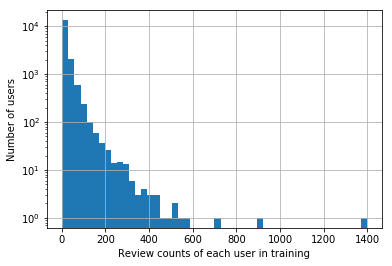

In [975]:
business_count_each_users.hist(bins=50)
plt.xlabel('Review counts of each user in training')
plt.ylabel('Number of users')
plt.yscale('log')
plt.show()

This histogram shows sizes of training sets each for each user parameter training. The distribution is very right-skewed (i.e., a lot of users with a small number of reviews). There is one user who had almost 1400 business reviews (in the training set).

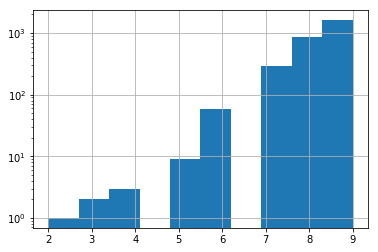

In [972]:
business_count_each_users[business_count_each_users<10].hist()
plt.yscale('log')
plt.show()

In [967]:
sum(business_count_each_users<10)

2829

Cross validation for each user is feasible since many users (almost 3000) have not even 10 business reviews in the training set, so I will manually tune hyper-parameters when necessary.

In [977]:
def training_test_algorithm_content_based_1(df_train, df_test, regr, counts=True):
    '''
    Function that trains and tests linear models and outputs results.
    '''    
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    mu = df_train.stars.mean()  
    
    for u_id in df_test.user_id.unique():
            
            X_train = df_train[df_train.user_id==u_id][feature_col].values
            X_test = df_test[df_test.user_id==u_id][feature_col].values
            y_train = df_train[df_train.user_id==u_id][target_col].values
            y_test = df_test[df_test.user_id==u_id][target_col].values
            #X_train, X_test, y_train, y_test = get_X_y_each_user(df_train, df_test, u_id)
            
            if len(y_train)<2: #cannot train for this user
                y_pred = mu # mean rating of training set
                if len(y_train) == 1:
                    SSE_train += (y_train.item(0) - mu)**2
                    count_users_1_in_train +=1
                else:
                    count_users_missing +=1

            else:
                clf = regr
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_train = np.reshape(y_train,(-1,1)) ## -1 for unspecified value 
                #print(clf.predict(X_train), y_train)
                #print(sum((clf.predict(X_train) - y_train)**2))
                SSE_train += sum((clf.predict(X_train) - y_train)**2)
            
            count_train += len(y_train)          
            y_test = np.reshape(y_test,(-1,1)) ## -1 for unspecified value 
            #print(y_pred, y_test)
            #print(sum((y_pred - y_test)**2))
            SSE_test += sum((y_pred - y_test)**2) # Add sum of SE for each user
            count_test += len(y_test)
    
    if counts:
        print('Number of users in test set:', df_test.user_id.nunique())
        print('Number of users missing in the training set:', count_users_missing)
        print('Number of users with one business in the training set:', count_users_1_in_train)
    
    MSE_train = SSE_train/count_train # mean SSE for all users
    #print(SSE_train)
    #print(MSE_train)
    RMSE_train = np.sqrt(MSE_train)
    #print(RMSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

##### Linear Regression

In [941]:
%%time
regr = LinearRegression(normalize=True, n_jobs=-1)
training_test_algorithm_content_based_1(df_sample_train, df_sample_test, regr)

Number of users in test set: 16388
Number of users missing in the training set: 0
Number of users with one business in the training set: 0

RMSE on training set: 0.3704

RMSE on test set: 50930839612556.086
Wall time: 28min 59s


Fortunately, there were no users with zero or one reviews in the training set, so the training set for every user was succefully trained (note that my training and testing function was prepared to use the average stars for those cases). 

This is the most simplest linear model and the overfitting is tragic. It is possibly due to small numbers of reviews for some users and large number of features. I definitely need regularizaion for my linear model and I chose Ridge regression.

##### Ridge

In [940]:
%%time
regr = Ridge(normalize=True, random_state=32, solver='auto') #alpha=1.0 by default
training_test_algorithm_content_based_1(df_sample_train, df_sample_test, regr)

Number of users in test set: 16388
Number of users missing in the training set: 0
Number of users with one business in the training set: 0

RMSE on training set: 0.6465

RMSE on test set: 2.216
Wall time: 30min 23s


Ridge is so much better than linear regression without regularization!! I will increase the strength of regularization to see if it can further improve the performance.

In [953]:
%%time
regr = Ridge(normalize=True, random_state=32, solver='auto', alpha=2) 
training_test_algorithm_content_based_1(df_sample_train, df_sample_test, regr)

Number of users in test set: 16388
Number of users missing in the training set: 0
Number of users with one business in the training set: 0

RMSE on training set: 0.7477

RMSE on test set: 1.5555
Wall time: 32min 22s


Yes, increasing regularization (from alpha=1 to alpha=2) improved the performance a lot!! RMSE was reduced from 2.216 to 1.5555. I can further improve this model by tuning alpha, but now I will try more complex models first and see if tuning them is more worth. 

I will try tree-based ensemble models, Random Forest and LightGBM. I found the above linear models and tree-based models work differently on numpy arrays, so I slightly modified my function for training and testing algorithms.

In [976]:
def training_test_algorithm_content_based_2(df_train, df_test, regr, counts=True):
    '''
    Function that trains and tests tree-based models and outputs results.
    '''     
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    mu = df_train.stars.mean()  
    
    for u_id in df_test.user_id.unique():
            
            X_train = df_train[df_train.user_id==u_id][feature_col].values
            X_test = df_test[df_test.user_id==u_id][feature_col].values
            y_train = df_train[df_train.user_id==u_id][target_col].values
            y_test = df_test[df_test.user_id==u_id][target_col].values
            #X_train, X_test, y_train, y_test = get_X_y_each_user(df_train, df_test, u_id)
            
            if len(y_train)<2: #cannot train for the user
                y_pred = mu # mean rating of training set
                if len(y_train) == 1:
                    SSE_train += (y_train - mu)**2
                    count_users_1_in_train +=1
                else:
                    count_users_missing +=1

            else:
                clf = regr
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
                #print(clf.predict(X_train), y_train)
                #print(sum((clf.predict(X_train) - y_train)**2))
                SSE_train += sum((clf.predict(X_train) - y_train)**2)
            
            count_train += len(y_train)          
            y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
            #print(y_pred, y_test)
            #print(sum((y_pred - y_test)**2))
            SSE_test += sum((y_pred - y_test)**2) # Add sum of SE for each user
            count_test += len(y_test)
    
    if counts:
        print('Number of users in test set:', df_test.user_id.nunique())
        print('Number of users missing in the training set:', count_users_missing)
        print('Number of users with one business in the training set:', count_users_1_in_train)
    
    MSE_train = SSE_train/count_train # mean SSE for all users
    #print(SSE_train)
    #print(MSE_train)
    RMSE_train = np.sqrt(MSE_train)
    #print(RMSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

##### Random Forest

In [ ]:
import warnings

In [945]:
%%time
warnings.filterwarnings('ignore')

regr = RandomForestRegressor(random_state=32, n_jobs=-1)
training_test_algorithm_content_based_2(df_sample_train, df_sample_test, regr)

Number of users in test set: 16388
Number of users missing in the training set: 0
Number of users with one business in the training set: 0

RMSE on training set: 0.503

RMSE on test set: 1.2889
Wall time: 2h 4min 12s


Random Forest is much better than Ridge regression models (although it is slow)! I will reduce the number of features for each estimator (max_features) since I have too many features (109 of them) comparing to the training set sizes. Square root of the number of all features is a popular choice for max_features.

In [946]:
%%time
warnings.filterwarnings('ignore')

regr = RandomForestRegressor(random_state=32, n_jobs=-1, max_features='sqrt' )
training_test_algorithm_content_based_2(df_sample_train, df_sample_test, regr)

Number of users in test set: 16388
Number of users missing in the training set: 0
Number of users with one business in the training set: 0

RMSE on training set: 0.4938

RMSE on test set: 1.2528
Wall time: 2h 4min 27s


This is better than using all features, but overfitting is still serious. I can definitely futher improve the performance by reducing overfitting (e.g. by setting maximum tree depth or maximum leaf nodes). However, this algorithm is so slow and Light GBM is known to be so much faster than Random Forest. Thus, I will move on to Light GBM and see if tuning LighrGBM is worth more than tuning RF.  

##### LightGBM

In [830]:
import lightgbm as lgb

In [954]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, 
                        feature_fraction=.1, n_estimators=500) 
training_test_algorithm_content_based_2(df_sample_train, df_sample_test, regr, counts=False)


RMSE on training set: 1.0873

RMSE on test set: 1.1869
Wall time: 42min 31s


LighGBM is so much faster than RF (42 min vs 2 hrs) and has much lower RMSE (1.1869 vs 1.2528)! Bagging won't be used for LightGBM due to those users with small training set sizes.

In [947]:
%%time
for fraction in [.1,.2,.5, 1]:
    print("Feature fraction:", fraction)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, 
                             feature_fraction=fraction) 
    training_test_algorithm_content_based_2(df_sample_train, df_sample_test, regr, counts=False)
    print()

Feature fraction: 0.1

RMSE on training set: 1.1056

RMSE on test set: 1.1829

Feature fraction: 0.2

RMSE on training set: 1.1036

RMSE on test set: 1.1825

Feature fraction: 0.5

RMSE on training set: 1.095

RMSE on test set: 1.1817

Feature fraction: 1

RMSE on training set: 1.0901

RMSE on test set: 1.1824

Wall time: 2h 33min 14s


Overfitting is not a big issue here, but I will tune some parameters to see if I can further reduce variance. 

Meanwhile I realized that making training and test sets for each user takes almost 30 minutes, so I stored them in a dictionary with user ids for keys whose corresponding values are a list of 4 datasets, X_train, X_test, y_train, and y_test.

In [1047]:
def make_data_dic_for_each_user(df_train, df_test, features):
    '''
    Makes user_id:[X_train,X_test,y_train,y_test] pair dictionary
    '''
    data_for_each_user = defaultdict(list) 
    for u_id in df_test.user_id.unique():
        data_for_each_user[u_id].append(df_train[df_train.user_id==u_id][features].values)  
        data_for_each_user[u_id].append(df_test[df_test.user_id==u_id][features].values)
        data_for_each_user[u_id].append(df_train[df_train.user_id==u_id].stars.values)
        data_for_each_user[u_id].append(df_test[df_test.user_id==u_id].stars.values)
    
    return data_for_each_user

In [1048]:
%%time
X_y_train_test_all_features = make_data_dic_for_each_user(df_sample_train, df_sample_test, feature_col)

Wall time: 27min 36s


In [1064]:
# mean of y_train
sum_stars=0
count=0
for datasets in X_y_train_test_all_features.values():
    sum_stars += sum(datasets[2]) #y_train
    count += len(datasets[2])
mu = sum_stars/count
print(mu)

3.7634797293849935


In [1065]:
def training_test_algorithm_content_based_3(X_y_train_test_dict, regr, counts=False):
    '''
    Function that trains and tests tree-based models and outputs results.
    The first argument X_y_train_test_dict is a premade dictionary with 
    user_id:[X_train,X_test,y_train,y_test] pairs for each user
    '''     
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    
    # mean of y_train
    sum_stars=0
    count=0
    for datasets in X_y_train_test_all_features.values():
        sum_stars += sum(datasets[2]) #y_train
        count += len(datasets[2])
    mu = sum_stars/count
    
    for X_train, X_test, y_train, y_test in X_y_train_test_dict.values():
            
            if len(y_train)<2: #cannot train for the user
                y_pred = mu # mean rating of training set
                if len(y_train) == 1:
                    SSE_train += (y_train - mu)**2
                    count_users_1_in_train +=1
                else:
                    count_users_missing +=1

            else:
                clf = regr
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
                #print(clf.predict(X_train), y_train)
                #print(sum((clf.predict(X_train) - y_train)**2))
                SSE_train += sum((clf.predict(X_train) - y_train)**2)
            
            count_train += len(y_train)          
            y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
            #print(y_pred, y_test)
            #print(sum((y_pred - y_test)**2))
            SSE_test += sum((y_pred - y_test)**2) # Add sum of SE for each user
            count_test += len(y_test)
    
    if counts:
        print('Number of users in test set:', df_test.user_id.nunique())
        print('Number of users missing in the training set:', count_users_missing)
        print('Number of users with one business in the training set:', count_users_1_in_train)
    
    MSE_train = SSE_train/count_train # mean SSE for all users
    #print(SSE_train)
    #print(MSE_train)
    RMSE_train = np.sqrt(MSE_train)
    #print(RMSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

In [1066]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_3(X_y_train_test_all_features, regr)


RMSE on training set: 1.095
RMSE on test set: 1.1817
Wall time: 1min 22s


This is blazingly fast!!! Now I got the power for tuning!!

In [1068]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5, 
                        max_depth=5, num_leaves=25) 
training_test_algorithm_content_based_3(X_y_train_test_all_features, regr)


RMSE on training set: 1.0956
RMSE on test set: 1.1817
Wall time: 1min 19s


Setting the max tree depth and leaves (ealier they were free to grow) did not change the performance at all. This means the trees were smaller than the maximum numbers I set.

In [1071]:
%%time
for d in [2,3,4]: # tuning max_depth
    for l in [20,30,40]: # tuning num_leaves
        for f in [.1,.2,.5,1.]: # tuning feature_fraction
            print("Max depth:", d, "   Number of leaves:", l, "  Number of features:", f)
            regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, 
                                     feature_fraction=f, max_depth=d, num_leaves=l) 
            training_test_algorithm_content_based_3(X_y_train_test_all_features, regr)
            print('---------------------------------------------------------------------\n')

Max depth: 2    Number of leaves: 20   Number of features: 0.1

RMSE on training set: 1.1066
RMSE on test set: 1.1829
---------------------------------------------------------------------

Max depth: 2    Number of leaves: 20   Number of features: 0.2

RMSE on training set: 1.1054
RMSE on test set: 1.1826
---------------------------------------------------------------------

Max depth: 2    Number of leaves: 20   Number of features: 0.5

RMSE on training set: 1.0991
RMSE on test set: 1.1817
---------------------------------------------------------------------

Max depth: 2    Number of leaves: 20   Number of features: 1.0

RMSE on training set: 1.0958
RMSE on test set: 1.1822
---------------------------------------------------------------------

Max depth: 2    Number of leaves: 30   Number of features: 0.1

RMSE on training set: 1.1066
RMSE on test set: 1.1829
---------------------------------------------------------------------

Max depth: 2    Number of leaves: 30   Number of featur

The most lowerest RMSE on the test set is still 1.1817 (in 7 hyper-parameter combinations), which is same as the RMSE of the model without restricted max depth and max number of leaves.

This RMSE value is the best among the models of content-based filtering, but it is still worse than the most of collaborative filtering algorithms; it is only better than the Normal Predictor (random guess around the mean) and Just mean algorithms. This could be possibly due to those users with a few business reviews (recall that there were almost 3,000 users with less than 10 reviews). The number of features (109) are too many for these users and even with a few features, it is hard to train a model with a few samples of data. Thus, I am going to try two things:
- Reduce the number of features
- Use other predicitons (such as mean or collaborative filtering predictions) for the users with the number of reviews less than some threshold (say 10)

###### Reduce the  number of features

To investigate which features are important, I am going to check feature importances of the user with the most reviews (almost 1400) found above.

In [991]:
# find the user with the most reviews in the training set
top_user_id = df_sample_test.user_id.unique()[business_count_each_users==business_count_each_users.max()].item()
top_user_id

'bLbSNkLggFnqwNNzzq-Ijw'

In [992]:
len(df_sample_train[df_sample_train.user_id==top_user_id])

1397

She or he left 1397 business reviews. I will train his/her data to get feature importances. 

In [1013]:
def training_test_algorithm_content_based_1_user(df_train, df_test, regr, user_id):
    print('user id:', user_id)
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0

    X_train = df_train[df_train.user_id==user_id][feature_col].values
    X_test = df_test[df_test.user_id==user_id][feature_col].values
    y_train = df_train[df_train.user_id==user_id][target_col].values
    y_test = df_test[df_test.user_id==user_id][target_col].values
    clf = regr 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
    SSE_train += sum((clf.predict(X_train) - y_train)**2)

    count_train += len(y_train)          
    y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
    SSE_test += sum((y_pred - y_test)**2) # Add sum of SE for each user
    count_test += len(y_test)

    MSE_train = SSE_train/count_train # mean SSE for all users
    RMSE_train = np.sqrt(MSE_train)
    print("RMSE on training set:", round(RMSE_train.item(0),4))

    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))
    
    return clf 

In [1014]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=1.) 
clf = training_test_algorithm_content_based_1_user(df_sample_train, df_sample_test, regr, top_user_id)

user id: bLbSNkLggFnqwNNzzq-Ijw
RMSE on training set: 0.6564
RMSE on test set: 0.7629
Wall time: 273 ms


In [1022]:
# Make a function that draw a feature importance plot
def plot_feature_importances(model_name, importances, feature_names, num_features=None, 
                             fig_size=None, ax=None):
    features_importances = pd.DataFrame(sorted(zip(feature_names, importances), 
                                           key = lambda tup: tup[1], reverse=True),
                                   columns=['features','importances'])
    data = features_importances[:num_features]
    data.plot('features','importances', kind='barh', ax=ax,
              color='blue', figsize=fig_size, legend = None)
    plt.gca().invert_yaxis() # reverse the order of features
    plt.ylabel('feature importances')
    if num_features:
        plt.title(model_name + '\nTop '+str(num_features))
    else: 
        plt.title(model_name + '\nAll Features')
    
    return features_importances # return all importances

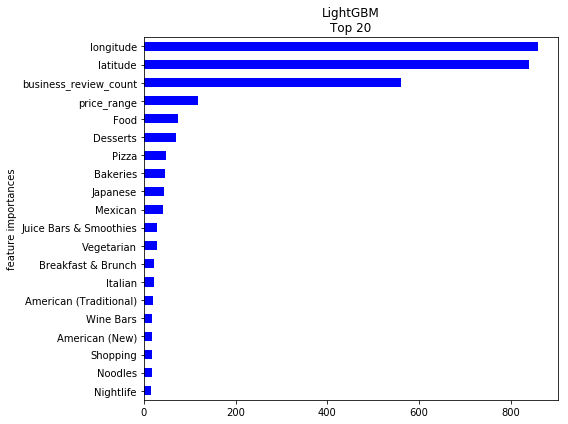

In [1023]:
# top 10 features
importances = plot_feature_importances('LightGBM', clf.feature_importances_, feature_col, 
                                       fig_size=(8,6), num_features=20)
plt.tight_layout() # need for savefig
plt.savefig("Feature_importances_LightGBM_20.png",format="png", dpi=300)

In [1030]:
importances[importances['importances']>0]

,features,importances
0,longitude,860
1,latitude,840
2,business_review_count,561
3,price_range,117
4,Food,75
5,Desserts,70
6,Pizza,47
7,Bakeries,46
8,Japanese,44
9,Mexican,41


The feature importances for the top users show only top 37 features some importances in the LightGBM model. Thus, I will use these 37 features to train the data.

In [1049]:
%%time
X_y_train_test_37_features = make_data_dic_for_each_user(df_sample_train, df_sample_test, list(importances[:37].features))

Wall time: 26min 23s


In [1074]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=1.) 
training_test_algorithm_content_based_3(X_y_train_test_37_features, regr)


RMSE on training set: 1.0903
RMSE on test set: 1.1826
Wall time: 1min 17s


In [1072]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_3(X_y_train_test_37_features, regr)


RMSE on training set: 1.0947
RMSE on test set: 1.1818
Wall time: 1min 14s


Using only 37 features gives almost the same RMSE on the test set (only 0.0001 bigger than using all features). The hyper-parameter feature_fraction=1. seems to overfit even with the 37 features. I will further reduce the number of features and check if that helps.

In [1073]:
%%time
X_y_train_test_5_features = make_data_dic_for_each_user(df_sample_train, df_sample_test, list(importances[:5].features))

Wall time: 28min 6s


In [1075]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=1.) 
training_test_algorithm_content_based_3(X_y_train_test_5_features, regr)


RMSE on training set: 1.091
RMSE on test set: 1.1827
Wall time: 1min 15s


In [1077]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_3(X_y_train_test_5_features, regr)


RMSE on training set: 1.096
RMSE on test set: 1.1818
Wall time: 1min 12s


In [1078]:
def make_data_dic_for_each_user_faster(df_train, df_test, features):
    '''
    Makes user_id:[X_train,X_test,y_train,y_test] pair dictionary
    Twice faster than the previous version, but use more memory
    '''
    data_for_each_user = defaultdict(list) 
    
    for u_id in df_test.user_id.unique():
        train = df_train[df_train.user_id==u_id]
        test =  df_test[df_test.user_id==u_id]
        
        data_for_each_user[u_id] = [train[features].values, test[features].values,
                                  train.stars.values, test.stars.values]
    
    return data_for_each_user

In [1079]:
%%time
X_y_train_test_10_features = make_data_dic_for_each_user_faster(df_sample_train, df_sample_test, list(importances[:10].features))

Wall time: 14min 25s


In [1081]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=1.) 
training_test_algorithm_content_based_3(X_y_train_test_10_features, regr)


RMSE on training set: 1.0909
RMSE on test set: 1.1826
Wall time: 1min 15s


In [1080]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_3(X_y_train_test_10_features, regr)


RMSE on training set: 1.0956
RMSE on test set: 1.1818
Wall time: 1min 13s


I tried 5 and 10 features and .5 (and .5 and 1. for feature_fraction), but they gave very similar results.

In [1198]:
def training_test_algorithm_content_based_4(X_y_train_test_dict, regr, threshold=2, counts=False):
    '''
    Function that trains and tests tree-based models and outputs results.
    The first argument X_y_train_test_dict is a premade dictionary with 
    user_id:[X_train,X_test,y_train,y_test] pairs for each user
    
    threshold:
    Users with the number of reviews less than the threshold will be not trained.
    Instead, the mean of stars in the training set will be their predictions.
    '''     
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    
    # mean of y_train
    sum_stars=0
    count=0
    for datasets in X_y_train_test_all_features.values():
        sum_stars += sum(datasets[2]) #y_train
        count += len(datasets[2])
    mu = sum_stars/count
    
    for X_train, X_test, y_train, y_test in X_y_train_test_dict.values():
            
            if len(y_train) < threshold: # users hard to train
                y_pred = mu # mean rating of training set
                if len(y_train) == 1:
                    SSE_train += (y_train - mu)**2
                    count_users_1_in_train +=1
                else:
                    count_users_missing +=1

            else:
                clf = regr
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
                SSE_train += sum((clf.predict(X_train) - y_train)**2)
            
            count_train += len(y_train)          
            y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
            SSE_test += sum((y_pred - y_test)**2) # Add sum of SE for each user
            count_test += len(y_test)
    
    if counts:
        print('Number of users in test set:', df_test.user_id.nunique())
        print('Number of users missing in the training set:', count_users_missing)
        print('Number of users with one business in the training set:', count_users_1_in_train)
    
    MSE_train = SSE_train/count_train # mean SSE for all users

    RMSE_train = np.sqrt(MSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

In [1084]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_4(X_y_train_test_10_features, regr, threshold=2)


RMSE on training set: 1.0956
RMSE on test set: 1.1818
Wall time: 1min 18s


In [1086]:
for num in [5,10,20,50,100]:
    print("Threshold:", num)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_content_based_4(X_y_train_test_all_features, regr, threshold=num)
    print('---------------------------------------------------------------------\n')    

Threshold: 5

RMSE on training set: 1.095
RMSE on test set: 1.1817
---------------------------------------------------------------------

Threshold: 10

RMSE on training set: 1.057
RMSE on test set: 1.1851
---------------------------------------------------------------------

Threshold: 20

RMSE on training set: 0.8659
RMSE on test set: 1.2016
---------------------------------------------------------------------

Threshold: 50

RMSE on training set: 0.5828
RMSE on test set: 1.2211
---------------------------------------------------------------------

Threshold: 100

RMSE on training set: 0.3756
RMSE on test set: 1.2293
---------------------------------------------------------------------



In [1087]:
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_4(X_y_train_test_37_features, regr, threshold=20)


RMSE on training set: 0.8655
RMSE on test set: 1.2016


In [1088]:
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_4(X_y_train_test_10_features, regr, threshold=20)


RMSE on training set: 0.8666
RMSE on test set: 1.2016


In [1089]:
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_content_based_4(X_y_train_test_5_features, regr, threshold=20)


RMSE on training set: 0.8672
RMSE on test set: 1.2016


In [1095]:
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5,
                         num_leaves=10, max_depth=2) 
training_test_algorithm_content_based_4(X_y_train_test_all_features, regr, threshold=20)


RMSE on training set: 0.8711
RMSE on test set: 1.2015


Using means for the users with low numbers of reviews actually made the predictions worse. As the threshold gets larger, the LightGBM overfits more and more. Reducing the number of features did not change RMSE. Now it's time to tune those hyper-paramters that reduce variance.

In [1096]:
%%time
for t in [5,10,20,50,100]: # 
    for l in [10,20,30,40,50]: # tuning num_leaves
        for d in [2,3,4,5]: # tuning tuning max_depth
            print("Trained over:", t, "  Number of leaves:", l, "  Max depth:", d)
            regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, 
                                     feature_fraction=.5, max_depth=d, num_leaves=l) 
            training_test_algorithm_content_based_4(X_y_train_test_all_features, regr, threshold=t)
            print('---------------------------------------------------------------------')

Trained over: 5   Number of leaves: 10   Max depth: 2

RMSE on training set: 1.0991
RMSE on test set: 1.1817
---------------------------------------------------------------------
Trained over: 5   Number of leaves: 10   Max depth: 3

RMSE on training set: 1.0971
RMSE on test set: 1.1817
---------------------------------------------------------------------
Trained over: 5   Number of leaves: 10   Max depth: 4

RMSE on training set: 1.0961
RMSE on test set: 1.1817
---------------------------------------------------------------------
Trained over: 5   Number of leaves: 10   Max depth: 5

RMSE on training set: 1.0957
RMSE on test set: 1.1817
---------------------------------------------------------------------
Trained over: 5   Number of leaves: 20   Max depth: 2

RMSE on training set: 1.0991
RMSE on test set: 1.1817
---------------------------------------------------------------------
Trained over: 5   Number of leaves: 20   Max depth: 3

RMSE on training set: 1.0971
RMSE on test set: 1.1


RMSE on training set: 0.8673
RMSE on test set: 1.2016
---------------------------------------------------------------------
Trained over: 20   Number of leaves: 20   Max depth: 5

RMSE on training set: 0.8667
RMSE on test set: 1.2016
---------------------------------------------------------------------
Trained over: 20   Number of leaves: 30   Max depth: 2

RMSE on training set: 0.8711
RMSE on test set: 1.2015
---------------------------------------------------------------------
Trained over: 20   Number of leaves: 30   Max depth: 3

RMSE on training set: 0.8686
RMSE on test set: 1.2016
---------------------------------------------------------------------
Trained over: 20   Number of leaves: 30   Max depth: 4

RMSE on training set: 0.8673
RMSE on test set: 1.2016
---------------------------------------------------------------------
Trained over: 20   Number of leaves: 30   Max depth: 5

RMSE on training set: 0.8667
RMSE on test set: 1.2016
---------------------------------------------


RMSE on training set: 0.3872
RMSE on test set: 1.2292
---------------------------------------------------------------------
Trained over: 100   Number of leaves: 40   Max depth: 3

RMSE on training set: 0.3818
RMSE on test set: 1.2293
---------------------------------------------------------------------
Trained over: 100   Number of leaves: 40   Max depth: 4

RMSE on training set: 0.3789
RMSE on test set: 1.2293
---------------------------------------------------------------------
Trained over: 100   Number of leaves: 40   Max depth: 5

RMSE on training set: 0.3774
RMSE on test set: 1.2293
---------------------------------------------------------------------
Trained over: 100   Number of leaves: 50   Max depth: 2

RMSE on training set: 0.3872
RMSE on test set: 1.2292
---------------------------------------------------------------------
Trained over: 100   Number of leaves: 50   Max depth: 3

RMSE on training set: 0.3818
RMSE on test set: 1.2293
----------------------------------------

Tuning the hyper-parameters did not improve the performance. The best RMSE for content-based filtering is still 1.1817. It looks like LGBM is doing its best and there is no room to improve using LGBM and these business features only.

### Context-aware Collaborative Filtering (In progress)

https://en.wikipedia.org/wiki/Collaborative_filtering#Context-aware_collaborative_filtering

Context-aware Collaborative Filtering can use context to get a vector for each user or item and use the ratings similar (or all) users or items 

In [1144]:
def training_test_algorithm_hybrid(X_y_train_test_dict, regr,
                                   train_set, test_set, algorithm, param_grid, n_cv):
    '''
    - Context-aware Collaborative Filtering
    - Predictions are average between BaselineOnly (collaborative) and LGBM (content-based)
    '''     
    
    ##### Collaborative filtering using Surprise #####
    data.raw_ratings = train_set

    # grid search cross validation
    gs = GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=n_cv, n_jobs=-1)
    gs.fit(data)
    best_algo = gs.best_estimator['rmse']

    # Compute performance on the whole training set 
    trainset = data.build_full_trainset()
    best_algo.fit(trainset)
    pred_train = best_algo.test(trainset.build_testset())
    
    # Compute performance on test set
    testset = data.construct_testset(test_set)  # testset is now the set B
    pred_test = best_algo.test(testset)
    
    
    ##### Ensemble with content-based filtering using Sklearn #####
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    
    for u_id, datasets in X_y_train_test_dict.items():
            y_pred_train_coll = [result.est for result in pred_train if result.uid==u_id]
            y_pred_test_coll = [result.est for result in pred_test if result.uid==u_id]
            
            X_train, X_test, y_train, y_test = datasets

            clf = regr
            clf.fit(X_train, y_train)
            
            y_pred_train = (y_pred_train_coll + clf.predict(X_train))/2
            y_pred_test = (y_pred_test_coll + clf.predict(X_test))/2
            
            y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
            SSE_train += sum((y_pred_train - y_train)**2)            
            count_train += len(y_train)          
            
            y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
            SSE_test += sum((y_pred_test - y_test)**2) # Add sum of SE for each user
            count_test += len(y_test)
    
    MSE_train = SSE_train/count_train # mean SSE for all users
    RMSE_train = np.sqrt(MSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

In [1145]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
param_grid = {'bsl_options':{'method': ['sgd']}}
training_test_algorithm_hybrid(X_y_train_test_all_features, regr,
                               train_raw_ratings, test_raw_ratings, BaselineOnly, 
                               param_grid, n_cv=3)

Estimating biases using sgd...

RMSE on training set: 1.0402
RMSE on test set: 1.1127
Wall time: 20min 19s


- very slow due to collecting data for each user

In [1114]:
   # Collaborative filtering using Surprise
    data.raw_ratings = train_raw_ratings

    # grid search cross validation
    param_grid = {'bsl_options':{'method': ['sgd']}}
    gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
    gs.fit(data)
    best_algo = gs.best_estimator['rmse']

    # Compute performance on the whole training set 
    trainset = data.build_full_trainset()
    best_algo.fit(trainset)
    pred_train = best_algo.test(trainset.build_testset())
    
    # Compute performance on test set
    testset = data.construct_testset(test_raw_ratings)  # testset is now the set B
    pred_test = best_algo.test(testset)
    print('Test set', end='  ')
    accuracy.rmse(pred_test)

Estimating biases using sgd...
Test set  RMSE: 1.0891


1.0890715889329599

In [1150]:
pred_test[:3]

[Prediction(uid='rdz9QHEPoecQ7DJk49ZI-g', iid='ZrXYLXcEcDvYYBErmafobg', r_ui=4.0, est=4.39586816967608, details={'was_impossible': False}),
 Prediction(uid='uByIGcI5EJeKNGyBtCkWBw', iid='HyKxWC9PrqlODjO-CBCIZA', r_ui=4.0, est=2.701837582892849, details={'was_impossible': False}),
 Prediction(uid='jmyunODJvYT7n7LCgotAyQ', iid='0s1DqJlSSgR1Ftg9Q_HEOg', r_ui=4.0, est=3.2560633794744436, details={'was_impossible': False})]

In [1117]:
for result in pred_test:
    if result.uid=='rdz9QHEPoecQ7DJk49ZI-g':
        print(result.iid, result.est)

ZrXYLXcEcDvYYBErmafobg 4.39586816967608
BjrKNWhtQkedHw8hP_0Bjg 4.208314859353514


In [1130]:
[result.est for result in pred_test if result.uid=='rdz9QHEPoecQ7DJk49ZI-g']

[4.39586816967608, 4.208314859353514]

In [1149]:
X_y_train_test_all_features['rdz9QHEPoecQ7DJk49ZI-g'][3]

array([4, 4], dtype=int64)

In [1155]:
def baseline_predicitons_each_user(user_ids, train_set, test_set, algorithm, param_grid, n_cv=3):
    ##### Collaborative filtering using Surprise #####
    data.raw_ratings = train_set

    # grid search cross validation
    gs = GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=n_cv, n_jobs=-1)
    gs.fit(data)
    best_algo = gs.best_estimator['rmse']

    # Compute performance on the whole training set 
    trainset = data.build_full_trainset()
    best_algo.fit(trainset)
    pred_train = best_algo.test(trainset.build_testset())
    
    # Compute performance on test set
    testset = data.construct_testset(test_set)  # testset is now the set B
    pred_test = best_algo.test(testset)
    
    # Save the result
    pred_each_user_dic = defaultdict(list)
    for u_id in user_ids:
            y_pred_train_coll = [result.est for result in pred_train if result.uid==u_id]
            y_pred_test_coll = [result.est for result in pred_test if result.uid==u_id]
            pred_each_user_dic[u_id] = [y_pred_train_coll, y_pred_test_coll]
    
    return  pred_each_user_dic

In [1156]:
%%time
param_grid = {'bsl_options':{'method': ['sgd']}}
y_pred_train_test_coll = baseline_predicitons_each_user(df_sample_test.user_id.unique(),
                                          train_raw_ratings, test_raw_ratings, BaselineOnly, param_grid)

Estimating biases using sgd...
Wall time: 11min 14s


In [1164]:
def training_test_algorithm_hybrid_2(X_y_train_test_dict, regr, y_pred_train_test_coll, threshold=2):
    '''
    - Context-aware Collaborative Filtering
    - Much faster from the original version because of precalculated BaselineOnly predictions (y_pred_train_test_coll)
    - Predictions are average between BaselineOnly (collaborative) and LGBM (content-based)
    - If the number of trainings for a user is less than threshold, use BaselineOnly 
    '''      
    ##### Ensemble with content-based filtering using Sklearn #####
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    
    for u_id, datasets in X_y_train_test_dict.items():
        
        y_pred_train_coll, y_pred_test_coll = y_pred_train_test_coll[u_id]
        X_train, X_test, y_train, y_test = datasets
        
        if len(y_train) < threshold: # users hard to train
            y_pred_train = y_pred_train_coll
            y_pred_test = y_pred_test_coll
        else: 
            clf = regr
            clf.fit(X_train, y_train)
            y_pred_train = (y_pred_train_coll + clf.predict(X_train))/2
            y_pred_test = (y_pred_test_coll + clf.predict(X_test))/2
            
        y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
        SSE_train += sum((y_pred_train - y_train)**2)            
        count_train += len(y_train)          
            
        y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
        SSE_test += sum((y_pred_test - y_test)**2) # Add sum of SE for each user
        count_test += len(y_test)
    
    MSE_train = SSE_train/count_train # mean SSE for all users
    RMSE_train = np.sqrt(MSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

In [1161]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_hybrid_2(X_y_train_test_all_features, regr, y_pred_train_test_coll)


RMSE on training set: 1.0402
RMSE on test set: 1.1127
Wall time: 1min 23s


In [1162]:
%%time
regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
training_test_algorithm_hybrid_2(X_y_train_test_all_features, regr, y_pred_train_test_coll, threshold=10)


RMSE on training set: 1.0396
RMSE on test set: 1.1085
Wall time: 1min 19s


In [1166]:
for t in [10,20,50,100]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_hybrid_2(X_y_train_test_all_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 10

RMSE on training set: 1.0396
RMSE on test set: 1.1085
------------------------------------------------
Baseline if less than 20

RMSE on training set: 1.0329
RMSE on test set: 1.0982
------------------------------------------------
Baseline if less than 50

RMSE on training set: 1.0249
RMSE on test set: 1.0919
------------------------------------------------
Baseline if less than 100

RMSE on training set: 1.0252
RMSE on test set: 1.0898
------------------------------------------------


In [1174]:
for t in [200,300,400,500,600,800,1000]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_hybrid_2(X_y_train_test_all_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 200

RMSE on training set: 1.0268
RMSE on test set: 1.0891
------------------------------------------------
Baseline if less than 300

RMSE on training set: 1.0278
RMSE on test set: 1.0891
------------------------------------------------
Baseline if less than 400

RMSE on training set: 1.0281
RMSE on test set: 1.0892
------------------------------------------------
Baseline if less than 500

RMSE on training set: 1.0283
RMSE on test set: 1.0892
------------------------------------------------
Baseline if less than 600

RMSE on training set: 1.0284
RMSE on test set: 1.0891
------------------------------------------------
Baseline if less than 800

RMSE on training set: 1.0284
RMSE on test set: 1.0891
------------------------------------------------
Baseline if less than 1000

RMSE on training set: 1.0285
RMSE on test set: 1.0891
------------------------------------------------


In [1167]:
def training_test_algorithm_hybrid_3(X_y_train_test_dict, regr, y_pred_train_test_coll, threshold=2):
    '''
    - Context-aware Collaborative Filtering
    - USe precalculated BaselineOnly predictions (y_pred_train_test_coll)
    - Predictions are made by LGBM (content-based)
    - If the number of trainings for a user is less than threshold, use BaselineOnly
    '''      
    ##### Ensemble with content-based filtering using Sklearn #####
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    
    for u_id, datasets in X_y_train_test_dict.items():
        
        y_pred_train_coll, y_pred_test_coll = y_pred_train_test_coll[u_id]
        X_train, X_test, y_train, y_test = datasets
        
        if len(y_train) < threshold: # users hard to train
            y_pred_train = y_pred_train_coll
            y_pred_test = y_pred_test_coll
        else: 
            clf = regr
            clf.fit(X_train, y_train)
            y_pred_train = clf.predict(X_train)
            y_pred_test = clf.predict(X_test)
            
        y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
        SSE_train += sum((y_pred_train - y_train)**2)            
        count_train += len(y_train)          
            
        y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
        SSE_test += sum((y_pred_test - y_test)**2) # Add sum of SE for each user
        count_test += len(y_test)
    
    MSE_train = SSE_train/count_train # mean SSE for all users
    RMSE_train = np.sqrt(MSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

In [1168]:
for t in [10,20,50,100]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_hybrid_3(X_y_train_test_all_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 10

RMSE on training set: 1.0905
RMSE on test set: 1.1671
------------------------------------------------
Baseline if less than 20

RMSE on training set: 1.0654
RMSE on test set: 1.1324
------------------------------------------------
Baseline if less than 50

RMSE on training set: 1.0361
RMSE on test set: 1.1083
------------------------------------------------
Baseline if less than 100

RMSE on training set: 1.0289
RMSE on test set: 1.0974
------------------------------------------------


In [1173]:
for t in [200,300,400,500,600,800,1000]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_hybrid_3(X_y_train_test_all_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 200

RMSE on training set: 1.0283
RMSE on test set: 1.0921
------------------------------------------------
Baseline if less than 300

RMSE on training set: 1.0284
RMSE on test set: 1.0904
------------------------------------------------
Baseline if less than 400

RMSE on training set: 1.0286
RMSE on test set: 1.0902
------------------------------------------------
Baseline if less than 500

RMSE on training set: 1.0285
RMSE on test set: 1.0897
------------------------------------------------
Baseline if less than 600

RMSE on training set: 1.0285
RMSE on test set: 1.0894
------------------------------------------------
Baseline if less than 800

RMSE on training set: 1.0285
RMSE on test set: 1.0893
------------------------------------------------
Baseline if less than 1000

RMSE on training set: 1.0286
RMSE on test set: 1.0892
------------------------------------------------


In [1184]:
for t in [10,20,50,100, 200,300,400,500,600,800,1000]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=1.) 
    training_test_algorithm_hybrid_3(X_y_train_test_5_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 10

RMSE on training set: 1.0865
RMSE on test set: 1.1681
------------------------------------------------
Baseline if less than 20

RMSE on training set: 1.0613
RMSE on test set: 1.1334
------------------------------------------------
Baseline if less than 50

RMSE on training set: 1.0326
RMSE on test set: 1.1092
------------------------------------------------
Baseline if less than 100

RMSE on training set: 1.0271
RMSE on test set: 1.0979
------------------------------------------------
Baseline if less than 200

RMSE on training set: 1.0276
RMSE on test set: 1.0921
------------------------------------------------
Baseline if less than 300

RMSE on training set: 1.0281
RMSE on test set: 1.0905
------------------------------------------------
Baseline if less than 400

RMSE on training set: 1.0284
RMSE on test set: 1.0903
------------------------------------------------
Baseline if less than 500

RMSE on training set: 1.0284
RMSE on test set: 1.0897
------------

In [1182]:
for t in [10,20,50,100, 200,300,400,500,600,800,1000]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_hybrid_3(X_y_train_test_5_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 10

RMSE on training set: 1.0915
RMSE on test set: 1.1672
------------------------------------------------
Baseline if less than 20

RMSE on training set: 1.0664
RMSE on test set: 1.1324
------------------------------------------------
Baseline if less than 50

RMSE on training set: 1.0374
RMSE on test set: 1.1084
------------------------------------------------
Baseline if less than 100

RMSE on training set: 1.0301
RMSE on test set: 1.0975
------------------------------------------------
Baseline if less than 200

RMSE on training set: 1.029
RMSE on test set: 1.0923
------------------------------------------------
Baseline if less than 300

RMSE on training set: 1.0287
RMSE on test set: 1.0906
------------------------------------------------
Baseline if less than 400

RMSE on training set: 1.0288
RMSE on test set: 1.0903
------------------------------------------------
Baseline if less than 500

RMSE on training set: 1.0286
RMSE on test set: 1.0898
-------------

In [1186]:
for t in [10,20,50,100, 200,300,400,500,600,800,1000]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_hybrid_2(X_y_train_test_5_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 10

RMSE on training set: 1.0402
RMSE on test set: 1.1085
------------------------------------------------
Baseline if less than 20

RMSE on training set: 1.0335
RMSE on test set: 1.0982
------------------------------------------------
Baseline if less than 50

RMSE on training set: 1.0255
RMSE on test set: 1.092
------------------------------------------------
Baseline if less than 100

RMSE on training set: 1.0257
RMSE on test set: 1.0899
------------------------------------------------
Baseline if less than 200

RMSE on training set: 1.0272
RMSE on test set: 1.0892
------------------------------------------------
Baseline if less than 300

RMSE on training set: 1.0279
RMSE on test set: 1.0892
------------------------------------------------
Baseline if less than 400

RMSE on training set: 1.0282
RMSE on test set: 1.0893
------------------------------------------------
Baseline if less than 500

RMSE on training set: 1.0283
RMSE on test set: 1.0892
-------------

In [1185]:
for t in [10,20,50,100, 200,300,400,500,600,800,1000]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=1.) 
    training_test_algorithm_hybrid_2(X_y_train_test_5_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 10

RMSE on training set: 1.0373
RMSE on test set: 1.1086
------------------------------------------------
Baseline if less than 20

RMSE on training set: 1.0305
RMSE on test set: 1.0983
------------------------------------------------
Baseline if less than 50

RMSE on training set: 1.0229
RMSE on test set: 1.092
------------------------------------------------
Baseline if less than 100

RMSE on training set: 1.0241
RMSE on test set: 1.0898
------------------------------------------------
Baseline if less than 200

RMSE on training set: 1.0264
RMSE on test set: 1.0891
------------------------------------------------
Baseline if less than 300

RMSE on training set: 1.0276
RMSE on test set: 1.0891
------------------------------------------------
Baseline if less than 400

RMSE on training set: 1.028
RMSE on test set: 1.0892
------------------------------------------------
Baseline if less than 500

RMSE on training set: 1.0282
RMSE on test set: 1.0891
--------------

In [1193]:
def training_test_algorithm_hybrid_4(X_y_train_test_dict, regr, y_pred_train_test_coll, threshold=10):
    '''
    - Context-aware Collaborative Filtering
    - USe precalculated BaselineOnly predictions (y_pred_train_test_coll)
    - Predictions are made by LGBM (content-based) cross-validated (cv=5)
    - If the number of trainings for a user is less than threshold, use BaselineOnly
    - Due to cross validation with 5 folds, the threshold has to be at least 5.
    '''      
    ##### Ensemble with content-based filtering using Sklearn #####
    SSE_train = 0
    SSE_test = 0
    count_train = 0
    count_test = 0
    count_users_missing = 0
    count_users_1_in_train = 0
    
    for u_id, datasets in X_y_train_test_dict.items():
        
        y_pred_train_coll, y_pred_test_coll = y_pred_train_test_coll[u_id]
        X_train, X_test, y_train, y_test = datasets
        
        if len(y_train) < threshold: # users hard to train
            y_pred_train = y_pred_train_coll
            y_pred_test = y_pred_test_coll
        else: 
            param_grid_skl={}
            cv = GridSearchCV_skl(regr,param_grid_skl, cv=5, scoring='neg_mean_squared_error') # scoring='neg_mean_squared_error'??
            cv.fit(X_train, y_train)
            y_pred_train = cv.predict(X_train)
            y_pred_test = cv.predict(X_test)
            
        y_train = np.reshape(y_train,(1,-1))[0] ## -1 for unspecified value 
        SSE_train += sum((y_pred_train - y_train)**2)            
        count_train += len(y_train)          
            
        y_test = np.reshape(y_test,(1,-1))[0] ## -1 for unspecified value 
        SSE_test += sum((y_pred_test - y_test)**2) # Add sum of SE for each user
        count_test += len(y_test)
    
    MSE_train = SSE_train/count_train # mean SSE for all users
    RMSE_train = np.sqrt(MSE_train)
    print("\nRMSE on training set:", round(RMSE_train.item(0),4))
    
    MSE_test = SSE_test/count_test # mean SSE for all users
    RMSE_test = np.sqrt(MSE_test)
    print("RMSE on test set:", round(RMSE_test.item(0),4))

In [1194]:
for t in [5,10,20,50,100,200,500]:
    print("Baseline if less than", t)
    regr = lgb.LGBMRegressor(random_state=32, learning_rate=0.01, feature_fraction=.5) 
    training_test_algorithm_hybrid_4(X_y_train_test_all_features, regr, y_pred_train_test_coll, threshold=t)
    print('------------------------------------------------')

Baseline if less than 5

RMSE on training set: 1.095
RMSE on test set: 1.1817
------------------------------------------------
Baseline if less than 10

RMSE on training set: 1.0905
RMSE on test set: 1.1671
------------------------------------------------
Baseline if less than 20

RMSE on training set: 1.0654
RMSE on test set: 1.1324
------------------------------------------------
Baseline if less than 50

RMSE on training set: 1.0361
RMSE on test set: 1.1083
------------------------------------------------
Baseline if less than 100

RMSE on training set: 1.0289
RMSE on test set: 1.0974
------------------------------------------------
Baseline if less than 200

RMSE on training set: 1.0283
RMSE on test set: 1.0921
------------------------------------------------
Baseline if less than 500

RMSE on training set: 1.0285
RMSE on test set: 1.0897
------------------------------------------------


### References

Surprise
https://surprise.readthedocs.io/en/stable/index.html
